In [71]:
import numpy as np
from random import shuffle

MAX_WORD_LENGTH = 16
NUM_TOKENS = 26

def read_lines(filename):
    lines = []
    with open(filename) as f:
        lines = f.readlines()
    return [line.strip() for line in lines]

def encode_token(c):
    ar = np.zeros(NUM_TOKENS)
    ar[ord(c) - ord('a')] = 1
    return ar

def encode_word_onehot(s, dim=1): # one-hot
    ew = np.array([encode_token(c) for c in s])
    while len(ew) < MAX_WORD_LENGTH: # add zero padding
        ew = np.vstack([ew, np.zeros(NUM_TOKENS)])
    if dim == 1:
        ew = np.reshape(ew, (-1))
    return ew

def encode_word_bag(s, dim=1): # bag of chars
    ew = np.zeros(NUM_TOKENS)
    for c in s:
        ew += encode_token(c)
    if dim == 1:
        ew = np.reshape(ew, (-1))
    return ew

def make_vectors(ones, zeros):
    # append the correct class
    vs = [[i, 1] for i in ones] + [[i, 0] for i in zeros]
    # shuffle so the order is random
    shuffle(vs)
    vs = np.array(vs)
    # get the X and y part
    X = vs[:, 0]
    y = vs[:, 1]
    # make it the rigt shape and type so SKL is happy
    X = np.vstack(X)
    y = y.reshape(X.shape[0], 1)
    y = y.astype('int')
    return X, y

def make_train_test_vectors(ones_train, ones_test, zeros_train, zeros_test, encode_func):
    X_train, y_train = make_vectors([encode_func(w) for w in ones_train], [encode_func(w) for w in zeros_train])
    X_test, y_test = make_vectors([encode_func(w) for w in ones_test], [encode_func(w) for w in zeros_test])
    return X_train, X_test, y_train, y_test

en_train = read_lines('en_train.txt')
ar_train = read_lines('ar_train.txt')
en_test = read_lines('en_test.txt')
ar_test = read_lines('ar_test.txt')

In [91]:
import sys
import json
import timeit
import string
import random
import warnings
import matplotlib.pyplot as plt
from scipy.sparse import hstack, vstack
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
%matplotlib inline

ignore_warnings=[DeprecationWarning, FutureWarning, DataConversionWarning, ConvergenceWarning]
for w in ignore_warnings: warnings.filterwarnings('ignore', category=w)

RANDOM_STATE = 6917

def eval_models(model_specs, X_train, X_test, y_train):
    models = []
    names = []
    train_probs = []
    test_probs = []
    train_preds = []
    test_preds = []
    for classifier, kwargs in model_specs:
        name = '%s%s' % (classifier.__name__, json.dumps(kwargs))
        print('Running %s...' % name)
        start = timeit.default_timer()
        model = classifier(**kwargs, random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        y_train_prob = model.predict_proba(X_train)
        y_test_prob = model.predict_proba(X_test)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        stop = timeit.default_timer()
        elapsed = stop - start
        print('^ Done, took %ds' % elapsed)
        name = '%s runtime=%ds' % (name, elapsed)
        models.append(model)
        names.append(name)
        train_probs.append(y_train_prob[:, 1])
        test_probs.append(y_test_prob[:, 1])
        train_preds.append(y_train_pred)
        test_preds.append(y_test_pred)
    return models, names, train_probs, test_probs, train_preds, test_preds

def print_roc_curves(names, probs, preds, y, title):
    plt.figure(figsize=(10, 10))
    for name, y_prob, y_pred in zip(names, probs, preds):
        fpr, tpr, thresholds = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        fpr = np.concatenate([[0], fpr])
        tpr = np.concatenate([[0], tpr])
        accuracy = accuracy_score(y_pred, y)
        plt.plot(fpr, tpr, lw=2, label='%s  auc=%0.2f accu=%0.2f)' % (name, roc_auc, accuracy))
        print('%s accuracy=%0.2f)' % (name, accuracy))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('roc %s' % title)
    plt.legend(loc="lower right")
    plt.show()

def run_eval_models(model_specs, X_train, X_test, y_train, y_test):
    models, names, train_probs, test_probs, train_preds, test_preds = eval_models(model_specs, X_train, X_test, y_train)
    print_roc_curves(names, train_probs, train_preds, y_train, 'train')
    print_roc_curves(names, test_probs, test_preds, y_test, 'test')
    return models, names, train_probs, test_probs

model_specs = [
    (LogisticRegression, dict()),
    (DecisionTreeClassifier, dict(max_depth=10)),
    (DecisionTreeClassifier, dict(max_depth=20)),
    (DecisionTreeClassifier, dict(max_depth=40)),
    (RandomForestClassifier, dict(max_depth=10, n_estimators=25)),
    (RandomForestClassifier, dict(max_depth=20, n_estimators=25)),
    (RandomForestClassifier, dict(max_depth=40, n_estimators=25)),
    (GradientBoostingClassifier, dict(max_depth=10, n_estimators=25)),
    (GradientBoostingClassifier, dict(max_depth=20, n_estimators=25)),
    (GradientBoostingClassifier, dict(max_depth=40, n_estimators=25)),
    (MLPClassifier, dict(hidden_layer_sizes=(10),  tol=1e-5, max_iter=100)),
    (MLPClassifier, dict(hidden_layer_sizes=(50),  tol=1e-5, max_iter=100)),
]

Running LogisticRegression{}...
^ Done, took 0s
Running DecisionTreeClassifier{"max_depth": 10}...
^ Done, took 0s
Running DecisionTreeClassifier{"max_depth": 20}...
^ Done, took 0s
Running DecisionTreeClassifier{"max_depth": 40}...
^ Done, took 0s
Running RandomForestClassifier{"max_depth": 10, "n_estimators": 25}...
^ Done, took 0s
Running RandomForestClassifier{"max_depth": 20, "n_estimators": 25}...
^ Done, took 0s
Running RandomForestClassifier{"max_depth": 40, "n_estimators": 25}...
^ Done, took 0s
Running GradientBoostingClassifier{"max_depth": 10, "n_estimators": 25}...
^ Done, took 1s
Running GradientBoostingClassifier{"max_depth": 20, "n_estimators": 25}...
^ Done, took 4s
Running GradientBoostingClassifier{"max_depth": 40, "n_estimators": 25}...
^ Done, took 4s
Running MLPClassifier{"hidden_layer_sizes": 10, "tol": 1e-05, "max_iter": 100}...
^ Done, took 1s
Running MLPClassifier{"hidden_layer_sizes": 50, "tol": 1e-05, "max_iter": 100}...
^ Done, took 2s
LogisticRegression{} 

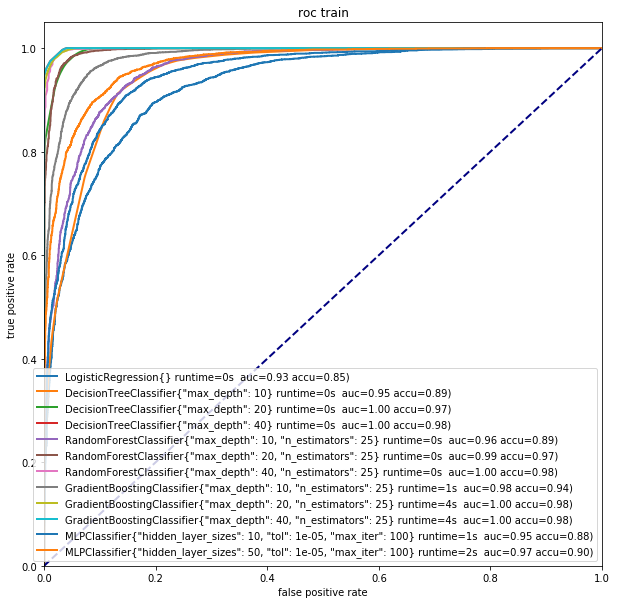

LogisticRegression{} runtime=0s accuracy=0.85)
DecisionTreeClassifier{"max_depth": 10} runtime=0s accuracy=0.85)
DecisionTreeClassifier{"max_depth": 20} runtime=0s accuracy=0.84)
DecisionTreeClassifier{"max_depth": 40} runtime=0s accuracy=0.83)
RandomForestClassifier{"max_depth": 10, "n_estimators": 25} runtime=0s accuracy=0.87)
RandomForestClassifier{"max_depth": 20, "n_estimators": 25} runtime=0s accuracy=0.88)
RandomForestClassifier{"max_depth": 40, "n_estimators": 25} runtime=0s accuracy=0.88)
GradientBoostingClassifier{"max_depth": 10, "n_estimators": 25} runtime=1s accuracy=0.88)
GradientBoostingClassifier{"max_depth": 20, "n_estimators": 25} runtime=4s accuracy=0.84)
GradientBoostingClassifier{"max_depth": 40, "n_estimators": 25} runtime=4s accuracy=0.83)
MLPClassifier{"hidden_layer_sizes": 10, "tol": 1e-05, "max_iter": 100} runtime=1s accuracy=0.87)
MLPClassifier{"hidden_layer_sizes": 50, "tol": 1e-05, "max_iter": 100} runtime=2s accuracy=0.89)


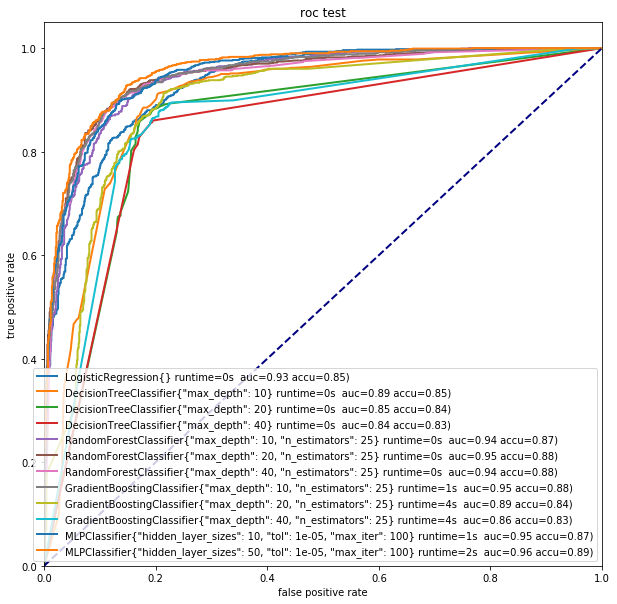

In [92]:
# run the above models on bag-of-chars vectors
X_train, X_test, y_train, y_test = make_train_test_vectors(ar_train, ar_test, en_train, en_test, encode_func=encode_word_bag)
models, names, train_probs, test_probs = run_eval_models(model_specs, X_train, X_test, y_train, y_test)

Running LogisticRegression{}...
^ Done, took 0s
Running DecisionTreeClassifier{"max_depth": 10}...
^ Done, took 0s
Running DecisionTreeClassifier{"max_depth": 20}...
^ Done, took 0s
Running DecisionTreeClassifier{"max_depth": 40}...
^ Done, took 0s
Running RandomForestClassifier{"max_depth": 10, "n_estimators": 25}...
^ Done, took 0s
Running RandomForestClassifier{"max_depth": 20, "n_estimators": 25}...
^ Done, took 0s
Running RandomForestClassifier{"max_depth": 40, "n_estimators": 25}...
^ Done, took 0s
Running GradientBoostingClassifier{"max_depth": 10, "n_estimators": 25}...
^ Done, took 9s
Running GradientBoostingClassifier{"max_depth": 20, "n_estimators": 25}...
^ Done, took 20s
Running GradientBoostingClassifier{"max_depth": 40, "n_estimators": 25}...
^ Done, took 31s
Running MLPClassifier{"hidden_layer_sizes": 10, "tol": 1e-05, "max_iter": 100}...
^ Done, took 4s
Running MLPClassifier{"hidden_layer_sizes": 50, "tol": 1e-05, "max_iter": 100}...
^ Done, took 6s
LogisticRegression{

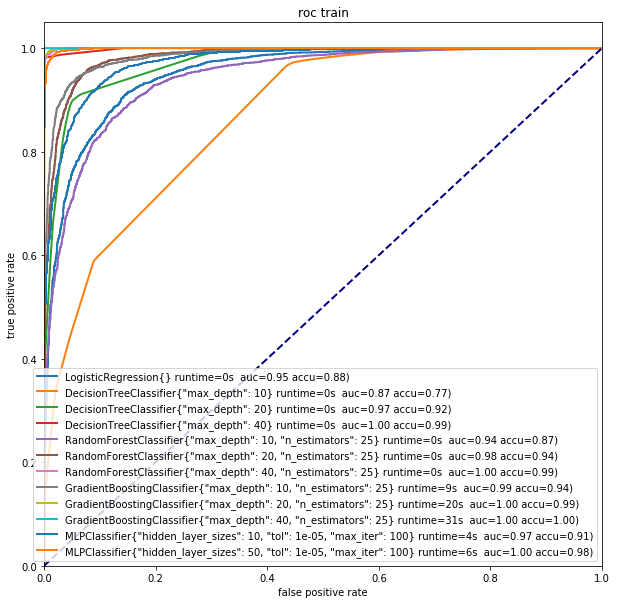

LogisticRegression{} runtime=0s accuracy=0.88)
DecisionTreeClassifier{"max_depth": 10} runtime=0s accuracy=0.75)
DecisionTreeClassifier{"max_depth": 20} runtime=0s accuracy=0.85)
DecisionTreeClassifier{"max_depth": 40} runtime=0s accuracy=0.87)
RandomForestClassifier{"max_depth": 10, "n_estimators": 25} runtime=0s accuracy=0.84)
RandomForestClassifier{"max_depth": 20, "n_estimators": 25} runtime=0s accuracy=0.88)
RandomForestClassifier{"max_depth": 40, "n_estimators": 25} runtime=0s accuracy=0.90)
GradientBoostingClassifier{"max_depth": 10, "n_estimators": 25} runtime=9s accuracy=0.89)
GradientBoostingClassifier{"max_depth": 20, "n_estimators": 25} runtime=20s accuracy=0.87)
GradientBoostingClassifier{"max_depth": 40, "n_estimators": 25} runtime=31s accuracy=0.87)
MLPClassifier{"hidden_layer_sizes": 10, "tol": 1e-05, "max_iter": 100} runtime=4s accuracy=0.89)
MLPClassifier{"hidden_layer_sizes": 50, "tol": 1e-05, "max_iter": 100} runtime=6s accuracy=0.92)


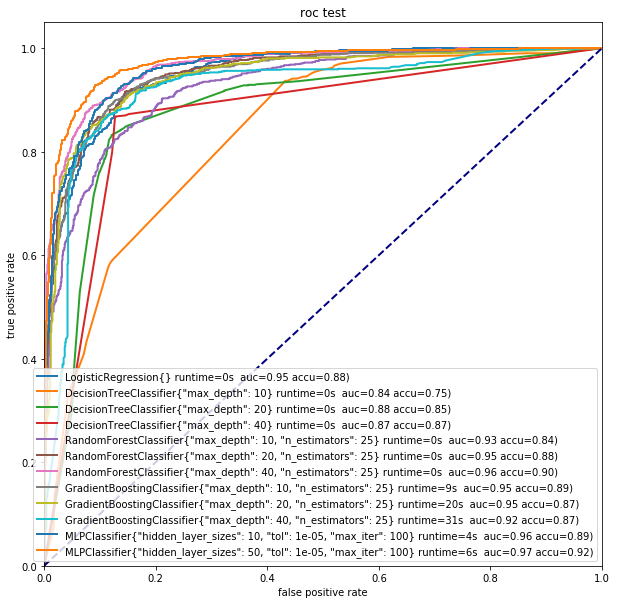

In [10]:
# run the above models on one-hot vectors
X_train, X_test, y_train, y_test = make_train_test_vectors(ar_train, ar_test, en_train, en_test, encode_func=encode_word_onehot)
models, names, train_probs, test_probs = run_eval_models(model_specs, X_train, X_test, y_train, y_test)

In [73]:
from __future__ import print_function
import numpy as np
import argparse
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import *
from matplotlib import pyplot as plt
%matplotlib inline
device = torch.device("cpu") # or 'gpu'

def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx > 0 and batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

def train_model(model, train_dataset, num_epochs):
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    losses = []
    accuracies = []
    start = timeit.default_timer()
    for epoch in range(0, num_epochs):
        losses.extend(train(model, device, train_loader, optimizer, epoch))
        accuracies.append(test(model, device, train_loader))
    stop = timeit.default_timer()
    elapsed = stop - start
    print('^ Done, took %ds' % elapsed)
    return losses, accuracies

class NameDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = torch.tensor(self.X[index]).view(self.X.shape[1]).type(torch.FloatTensor)
        y = int(self.y[index][0])
        return X, y

def make_torch_train_test_datasets(ar_train, ar_test, en_train, en_test, encode_func):
    X_train, X_test, y_train, y_test = make_train_test_vectors(ar_train, ar_test, en_train, en_test, encode_func)
    train_dataset = NameDataset(X_train, y_train)
    test_dataset = NameDataset(X_test, y_test)
    return train_dataset, test_dataset

class DNN(nn.Module):
    def __init__(self, vector_length):
        super(DNN, self).__init__()
        self.vector_length = vector_length
        self.fc1 = nn.Linear(self.vector_length, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 26)
        self.fc4 = nn.Linear(26, 2)

    def forward(self, x):
        x = x.view(-1, self.vector_length)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return F.log_softmax(x, dim=1)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(6*16*50, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward(self, x):
        x = x.view(-1, 1, MAX_WORD_LENGTH, 26)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 1)
        x = x.view(-1, 6*16*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)    

def test_label_predictions(model, test_dataset):
    model.eval()
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1000,
        shuffle=True)
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

def mean(li):
    return sum(li)/len(li)

def evaluate_model(model, losses, accuracies):
    plt.figure(figsize=(14, 4))
    plt.xlabel('training batch')
    plt.ylabel('loss')
    plt.plot([mean(losses[i:i+100]) for i in range(len(losses))])
    plt.figure(figsize=(14, 4))
    plt.xticks(range(len(accuracies)))
    plt.xlabel('training epoch')
    plt.ylabel('accuracy')
    plt.plot([mean(accuracies[i:i+10]) for i in range(len(accuracies))])
    actuals, predictions = test_label_predictions(model, test_dataset)
    print('Test data confusion matrix:')
    print(confusion_matrix(actuals, predictions))
    print('Test data accuracy score: %f' % accuracy_score(actuals, predictions))

Train Epoch: 0 [640/8000	(8%)]	Loss: 0.675649
Train Epoch: 0 [1280/8000	(16%)]	Loss: 0.695691
Train Epoch: 0 [1920/8000	(24%)]	Loss: 0.702763
Train Epoch: 0 [2560/8000	(32%)]	Loss: 0.700167
Train Epoch: 0 [3200/8000	(40%)]	Loss: 0.705156
Train Epoch: 0 [3840/8000	(48%)]	Loss: 0.692532
Train Epoch: 0 [4480/8000	(56%)]	Loss: 0.695875
Train Epoch: 0 [5120/8000	(64%)]	Loss: 0.700858
Train Epoch: 0 [5760/8000	(72%)]	Loss: 0.690913
Train Epoch: 0 [6400/8000	(80%)]	Loss: 0.687610
Train Epoch: 0 [7040/8000	(88%)]	Loss: 0.693573
Train Epoch: 0 [7680/8000	(96%)]	Loss: 0.690083

Average loss: 0.6934, Accuracy: 4000/8000 (50%)

Train Epoch: 1 [640/8000	(8%)]	Loss: 0.688585
Train Epoch: 1 [1280/8000	(16%)]	Loss: 0.689258
Train Epoch: 1 [1920/8000	(24%)]	Loss: 0.697774
Train Epoch: 1 [2560/8000	(32%)]	Loss: 0.699295
Train Epoch: 1 [3200/8000	(40%)]	Loss: 0.691113
Train Epoch: 1 [3840/8000	(48%)]	Loss: 0.692905
Train Epoch: 1 [4480/8000	(56%)]	Loss: 0.692936
Train Epoch: 1 [5120/8000	(64%)]	Loss: 0.6

Train Epoch: 13 [2560/8000	(32%)]	Loss: 0.680394
Train Epoch: 13 [3200/8000	(40%)]	Loss: 0.667821
Train Epoch: 13 [3840/8000	(48%)]	Loss: 0.662965
Train Epoch: 13 [4480/8000	(56%)]	Loss: 0.659423
Train Epoch: 13 [5120/8000	(64%)]	Loss: 0.685890
Train Epoch: 13 [5760/8000	(72%)]	Loss: 0.671220
Train Epoch: 13 [6400/8000	(80%)]	Loss: 0.643196
Train Epoch: 13 [7040/8000	(88%)]	Loss: 0.677710
Train Epoch: 13 [7680/8000	(96%)]	Loss: 0.662699

Average loss: 0.6647, Accuracy: 4000/8000 (50%)

Train Epoch: 14 [640/8000	(8%)]	Loss: 0.662420
Train Epoch: 14 [1280/8000	(16%)]	Loss: 0.657742
Train Epoch: 14 [1920/8000	(24%)]	Loss: 0.656067
Train Epoch: 14 [2560/8000	(32%)]	Loss: 0.648295
Train Epoch: 14 [3200/8000	(40%)]	Loss: 0.656460
Train Epoch: 14 [3840/8000	(48%)]	Loss: 0.654703
Train Epoch: 14 [4480/8000	(56%)]	Loss: 0.661911
Train Epoch: 14 [5120/8000	(64%)]	Loss: 0.671687
Train Epoch: 14 [5760/8000	(72%)]	Loss: 0.653235
Train Epoch: 14 [6400/8000	(80%)]	Loss: 0.653902
Train Epoch: 14 [7040

Train Epoch: 26 [1920/8000	(24%)]	Loss: 0.396199
Train Epoch: 26 [2560/8000	(32%)]	Loss: 0.297264
Train Epoch: 26 [3200/8000	(40%)]	Loss: 0.204045
Train Epoch: 26 [3840/8000	(48%)]	Loss: 0.243147
Train Epoch: 26 [4480/8000	(56%)]	Loss: 0.327649
Train Epoch: 26 [5120/8000	(64%)]	Loss: 0.255662
Train Epoch: 26 [5760/8000	(72%)]	Loss: 0.292130
Train Epoch: 26 [6400/8000	(80%)]	Loss: 0.221590
Train Epoch: 26 [7040/8000	(88%)]	Loss: 0.221075
Train Epoch: 26 [7680/8000	(96%)]	Loss: 0.454319

Average loss: 0.2910, Accuracy: 7032/8000 (88%)

Train Epoch: 27 [640/8000	(8%)]	Loss: 0.351490
Train Epoch: 27 [1280/8000	(16%)]	Loss: 0.372046
Train Epoch: 27 [1920/8000	(24%)]	Loss: 0.186111
Train Epoch: 27 [2560/8000	(32%)]	Loss: 0.227192
Train Epoch: 27 [3200/8000	(40%)]	Loss: 0.289576
Train Epoch: 27 [3840/8000	(48%)]	Loss: 0.182356
Train Epoch: 27 [4480/8000	(56%)]	Loss: 0.282220
Train Epoch: 27 [5120/8000	(64%)]	Loss: 0.277492
Train Epoch: 27 [5760/8000	(72%)]	Loss: 0.313962
Train Epoch: 27 [6400

Train Epoch: 39 [2560/8000	(32%)]	Loss: 0.185269
Train Epoch: 39 [3200/8000	(40%)]	Loss: 0.218487
Train Epoch: 39 [3840/8000	(48%)]	Loss: 0.184727
Train Epoch: 39 [4480/8000	(56%)]	Loss: 0.122437
Train Epoch: 39 [5120/8000	(64%)]	Loss: 0.213736
Train Epoch: 39 [5760/8000	(72%)]	Loss: 0.241607
Train Epoch: 39 [6400/8000	(80%)]	Loss: 0.326819
Train Epoch: 39 [7040/8000	(88%)]	Loss: 0.234318
Train Epoch: 39 [7680/8000	(96%)]	Loss: 0.326483

Average loss: 0.2175, Accuracy: 7309/8000 (91%)

Train Epoch: 40 [640/8000	(8%)]	Loss: 0.199985
Train Epoch: 40 [1280/8000	(16%)]	Loss: 0.316716
Train Epoch: 40 [1920/8000	(24%)]	Loss: 0.125641
Train Epoch: 40 [2560/8000	(32%)]	Loss: 0.242530
Train Epoch: 40 [3200/8000	(40%)]	Loss: 0.291215
Train Epoch: 40 [3840/8000	(48%)]	Loss: 0.258563
Train Epoch: 40 [4480/8000	(56%)]	Loss: 0.153125
Train Epoch: 40 [5120/8000	(64%)]	Loss: 0.252508
Train Epoch: 40 [5760/8000	(72%)]	Loss: 0.273065
Train Epoch: 40 [6400/8000	(80%)]	Loss: 0.245708
Train Epoch: 40 [7040

Train Epoch: 52 [2560/8000	(32%)]	Loss: 0.076226
Train Epoch: 52 [3200/8000	(40%)]	Loss: 0.200467
Train Epoch: 52 [3840/8000	(48%)]	Loss: 0.087006
Train Epoch: 52 [4480/8000	(56%)]	Loss: 0.136193
Train Epoch: 52 [5120/8000	(64%)]	Loss: 0.147155
Train Epoch: 52 [5760/8000	(72%)]	Loss: 0.139456
Train Epoch: 52 [6400/8000	(80%)]	Loss: 0.095627
Train Epoch: 52 [7040/8000	(88%)]	Loss: 0.097958
Train Epoch: 52 [7680/8000	(96%)]	Loss: 0.163444

Average loss: 0.1311, Accuracy: 7634/8000 (95%)

Train Epoch: 53 [640/8000	(8%)]	Loss: 0.111498
Train Epoch: 53 [1280/8000	(16%)]	Loss: 0.161220
Train Epoch: 53 [1920/8000	(24%)]	Loss: 0.104998
Train Epoch: 53 [2560/8000	(32%)]	Loss: 0.160158
Train Epoch: 53 [3200/8000	(40%)]	Loss: 0.134617
Train Epoch: 53 [3840/8000	(48%)]	Loss: 0.057605
Train Epoch: 53 [4480/8000	(56%)]	Loss: 0.152249
Train Epoch: 53 [5120/8000	(64%)]	Loss: 0.155356
Train Epoch: 53 [5760/8000	(72%)]	Loss: 0.163270
Train Epoch: 53 [6400/8000	(80%)]	Loss: 0.099416
Train Epoch: 53 [7040

Train Epoch: 65 [3200/8000	(40%)]	Loss: 0.060373
Train Epoch: 65 [3840/8000	(48%)]	Loss: 0.056454
Train Epoch: 65 [4480/8000	(56%)]	Loss: 0.052290
Train Epoch: 65 [5120/8000	(64%)]	Loss: 0.106654
Train Epoch: 65 [5760/8000	(72%)]	Loss: 0.109857
Train Epoch: 65 [6400/8000	(80%)]	Loss: 0.078174
Train Epoch: 65 [7040/8000	(88%)]	Loss: 0.129507
Train Epoch: 65 [7680/8000	(96%)]	Loss: 0.063599

Average loss: 0.0709, Accuracy: 7835/8000 (98%)

Train Epoch: 66 [640/8000	(8%)]	Loss: 0.058915
Train Epoch: 66 [1280/8000	(16%)]	Loss: 0.058908
Train Epoch: 66 [1920/8000	(24%)]	Loss: 0.103877
Train Epoch: 66 [2560/8000	(32%)]	Loss: 0.030735
Train Epoch: 66 [3200/8000	(40%)]	Loss: 0.080572
Train Epoch: 66 [3840/8000	(48%)]	Loss: 0.078030
Train Epoch: 66 [4480/8000	(56%)]	Loss: 0.073002
Train Epoch: 66 [5120/8000	(64%)]	Loss: 0.146142
Train Epoch: 66 [5760/8000	(72%)]	Loss: 0.090617
Train Epoch: 66 [6400/8000	(80%)]	Loss: 0.050742
Train Epoch: 66 [7040/8000	(88%)]	Loss: 0.043838
Train Epoch: 66 [7680

Train Epoch: 78 [3200/8000	(40%)]	Loss: 0.110669
Train Epoch: 78 [3840/8000	(48%)]	Loss: 0.034894
Train Epoch: 78 [4480/8000	(56%)]	Loss: 0.051785
Train Epoch: 78 [5120/8000	(64%)]	Loss: 0.046911
Train Epoch: 78 [5760/8000	(72%)]	Loss: 0.079420
Train Epoch: 78 [6400/8000	(80%)]	Loss: 0.021089
Train Epoch: 78 [7040/8000	(88%)]	Loss: 0.041634
Train Epoch: 78 [7680/8000	(96%)]	Loss: 0.047013

Average loss: 0.0344, Accuracy: 7945/8000 (99%)

Train Epoch: 79 [640/8000	(8%)]	Loss: 0.022319
Train Epoch: 79 [1280/8000	(16%)]	Loss: 0.026379
Train Epoch: 79 [1920/8000	(24%)]	Loss: 0.043350
Train Epoch: 79 [2560/8000	(32%)]	Loss: 0.055900
Train Epoch: 79 [3200/8000	(40%)]	Loss: 0.053661
Train Epoch: 79 [3840/8000	(48%)]	Loss: 0.028431
Train Epoch: 79 [4480/8000	(56%)]	Loss: 0.037962
Train Epoch: 79 [5120/8000	(64%)]	Loss: 0.024717
Train Epoch: 79 [5760/8000	(72%)]	Loss: 0.054763
Train Epoch: 79 [6400/8000	(80%)]	Loss: 0.075742
Train Epoch: 79 [7040/8000	(88%)]	Loss: 0.043351
Train Epoch: 79 [7680

Train Epoch: 91 [2560/8000	(32%)]	Loss: 0.026958
Train Epoch: 91 [3200/8000	(40%)]	Loss: 0.005508
Train Epoch: 91 [3840/8000	(48%)]	Loss: 0.022000
Train Epoch: 91 [4480/8000	(56%)]	Loss: 0.007407
Train Epoch: 91 [5120/8000	(64%)]	Loss: 0.029552
Train Epoch: 91 [5760/8000	(72%)]	Loss: 0.028428
Train Epoch: 91 [6400/8000	(80%)]	Loss: 0.043909
Train Epoch: 91 [7040/8000	(88%)]	Loss: 0.027565
Train Epoch: 91 [7680/8000	(96%)]	Loss: 0.011116

Average loss: 0.0153, Accuracy: 7988/8000 (100%)

Train Epoch: 92 [640/8000	(8%)]	Loss: 0.024415
Train Epoch: 92 [1280/8000	(16%)]	Loss: 0.016174
Train Epoch: 92 [1920/8000	(24%)]	Loss: 0.009616
Train Epoch: 92 [2560/8000	(32%)]	Loss: 0.017741
Train Epoch: 92 [3200/8000	(40%)]	Loss: 0.009956
Train Epoch: 92 [3840/8000	(48%)]	Loss: 0.005743
Train Epoch: 92 [4480/8000	(56%)]	Loss: 0.020178
Train Epoch: 92 [5120/8000	(64%)]	Loss: 0.018288
Train Epoch: 92 [5760/8000	(72%)]	Loss: 0.026046
Train Epoch: 92 [6400/8000	(80%)]	Loss: 0.038440
Train Epoch: 92 [704

Train Epoch: 104 [2560/8000	(32%)]	Loss: 0.008947
Train Epoch: 104 [3200/8000	(40%)]	Loss: 0.004847
Train Epoch: 104 [3840/8000	(48%)]	Loss: 0.023666
Train Epoch: 104 [4480/8000	(56%)]	Loss: 0.011676
Train Epoch: 104 [5120/8000	(64%)]	Loss: 0.007782
Train Epoch: 104 [5760/8000	(72%)]	Loss: 0.006806
Train Epoch: 104 [6400/8000	(80%)]	Loss: 0.004777
Train Epoch: 104 [7040/8000	(88%)]	Loss: 0.011311
Train Epoch: 104 [7680/8000	(96%)]	Loss: 0.014472

Average loss: 0.0077, Accuracy: 7998/8000 (100%)

Train Epoch: 105 [640/8000	(8%)]	Loss: 0.011885
Train Epoch: 105 [1280/8000	(16%)]	Loss: 0.003735
Train Epoch: 105 [1920/8000	(24%)]	Loss: 0.008065
Train Epoch: 105 [2560/8000	(32%)]	Loss: 0.009425
Train Epoch: 105 [3200/8000	(40%)]	Loss: 0.012063
Train Epoch: 105 [3840/8000	(48%)]	Loss: 0.007452
Train Epoch: 105 [4480/8000	(56%)]	Loss: 0.017784
Train Epoch: 105 [5120/8000	(64%)]	Loss: 0.006614
Train Epoch: 105 [5760/8000	(72%)]	Loss: 0.006877
Train Epoch: 105 [6400/8000	(80%)]	Loss: 0.010223
T

Train Epoch: 116 [7680/8000	(96%)]	Loss: 0.004857

Average loss: 0.0047, Accuracy: 8000/8000 (100%)

Train Epoch: 117 [640/8000	(8%)]	Loss: 0.008956
Train Epoch: 117 [1280/8000	(16%)]	Loss: 0.002753
Train Epoch: 117 [1920/8000	(24%)]	Loss: 0.003770
Train Epoch: 117 [2560/8000	(32%)]	Loss: 0.003171
Train Epoch: 117 [3200/8000	(40%)]	Loss: 0.008890
Train Epoch: 117 [3840/8000	(48%)]	Loss: 0.002100
Train Epoch: 117 [4480/8000	(56%)]	Loss: 0.003721
Train Epoch: 117 [5120/8000	(64%)]	Loss: 0.003153
Train Epoch: 117 [5760/8000	(72%)]	Loss: 0.008335
Train Epoch: 117 [6400/8000	(80%)]	Loss: 0.004039
Train Epoch: 117 [7040/8000	(88%)]	Loss: 0.008944
Train Epoch: 117 [7680/8000	(96%)]	Loss: 0.003637

Average loss: 0.0042, Accuracy: 8000/8000 (100%)

Train Epoch: 118 [640/8000	(8%)]	Loss: 0.002682
Train Epoch: 118 [1280/8000	(16%)]	Loss: 0.002748
Train Epoch: 118 [1920/8000	(24%)]	Loss: 0.005126
Train Epoch: 118 [2560/8000	(32%)]	Loss: 0.005358
Train Epoch: 118 [3200/8000	(40%)]	Loss: 0.002390
Tr

Train Epoch: 129 [5120/8000	(64%)]	Loss: 0.002987
Train Epoch: 129 [5760/8000	(72%)]	Loss: 0.004405
Train Epoch: 129 [6400/8000	(80%)]	Loss: 0.003233
Train Epoch: 129 [7040/8000	(88%)]	Loss: 0.002452
Train Epoch: 129 [7680/8000	(96%)]	Loss: 0.001670

Average loss: 0.0029, Accuracy: 8000/8000 (100%)

Train Epoch: 130 [640/8000	(8%)]	Loss: 0.004263
Train Epoch: 130 [1280/8000	(16%)]	Loss: 0.003267
Train Epoch: 130 [1920/8000	(24%)]	Loss: 0.003167
Train Epoch: 130 [2560/8000	(32%)]	Loss: 0.006165
Train Epoch: 130 [3200/8000	(40%)]	Loss: 0.006385
Train Epoch: 130 [3840/8000	(48%)]	Loss: 0.006280
Train Epoch: 130 [4480/8000	(56%)]	Loss: 0.003848
Train Epoch: 130 [5120/8000	(64%)]	Loss: 0.003218
Train Epoch: 130 [5760/8000	(72%)]	Loss: 0.004519
Train Epoch: 130 [6400/8000	(80%)]	Loss: 0.003253
Train Epoch: 130 [7040/8000	(88%)]	Loss: 0.003215
Train Epoch: 130 [7680/8000	(96%)]	Loss: 0.001375

Average loss: 0.0027, Accuracy: 8000/8000 (100%)

Train Epoch: 131 [640/8000	(8%)]	Loss: 0.002139
Tr

Train Epoch: 142 [3200/8000	(40%)]	Loss: 0.003606
Train Epoch: 142 [3840/8000	(48%)]	Loss: 0.002799
Train Epoch: 142 [4480/8000	(56%)]	Loss: 0.001415
Train Epoch: 142 [5120/8000	(64%)]	Loss: 0.002219
Train Epoch: 142 [5760/8000	(72%)]	Loss: 0.001447
Train Epoch: 142 [6400/8000	(80%)]	Loss: 0.003429
Train Epoch: 142 [7040/8000	(88%)]	Loss: 0.003324
Train Epoch: 142 [7680/8000	(96%)]	Loss: 0.000949

Average loss: 0.0022, Accuracy: 8000/8000 (100%)

Train Epoch: 143 [640/8000	(8%)]	Loss: 0.002179
Train Epoch: 143 [1280/8000	(16%)]	Loss: 0.001305
Train Epoch: 143 [1920/8000	(24%)]	Loss: 0.001169
Train Epoch: 143 [2560/8000	(32%)]	Loss: 0.003001
Train Epoch: 143 [3200/8000	(40%)]	Loss: 0.002045
Train Epoch: 143 [3840/8000	(48%)]	Loss: 0.001187
Train Epoch: 143 [4480/8000	(56%)]	Loss: 0.002391
Train Epoch: 143 [5120/8000	(64%)]	Loss: 0.001972
Train Epoch: 143 [5760/8000	(72%)]	Loss: 0.001656
Train Epoch: 143 [6400/8000	(80%)]	Loss: 0.004423
Train Epoch: 143 [7040/8000	(88%)]	Loss: 0.002037
T

Train Epoch: 155 [3200/8000	(40%)]	Loss: 0.000783
Train Epoch: 155 [3840/8000	(48%)]	Loss: 0.001605
Train Epoch: 155 [4480/8000	(56%)]	Loss: 0.002095
Train Epoch: 155 [5120/8000	(64%)]	Loss: 0.001672
Train Epoch: 155 [5760/8000	(72%)]	Loss: 0.002914
Train Epoch: 155 [6400/8000	(80%)]	Loss: 0.001315
Train Epoch: 155 [7040/8000	(88%)]	Loss: 0.002406
Train Epoch: 155 [7680/8000	(96%)]	Loss: 0.001453

Average loss: 0.0016, Accuracy: 8000/8000 (100%)

Train Epoch: 156 [640/8000	(8%)]	Loss: 0.002271
Train Epoch: 156 [1280/8000	(16%)]	Loss: 0.001817
Train Epoch: 156 [1920/8000	(24%)]	Loss: 0.002165
Train Epoch: 156 [2560/8000	(32%)]	Loss: 0.001163
Train Epoch: 156 [3200/8000	(40%)]	Loss: 0.003373
Train Epoch: 156 [3840/8000	(48%)]	Loss: 0.001851
Train Epoch: 156 [4480/8000	(56%)]	Loss: 0.001180
Train Epoch: 156 [5120/8000	(64%)]	Loss: 0.001095
Train Epoch: 156 [5760/8000	(72%)]	Loss: 0.001893
Train Epoch: 156 [6400/8000	(80%)]	Loss: 0.000871
Train Epoch: 156 [7040/8000	(88%)]	Loss: 0.001455
T

Train Epoch: 168 [1920/8000	(24%)]	Loss: 0.001299
Train Epoch: 168 [2560/8000	(32%)]	Loss: 0.000688
Train Epoch: 168 [3200/8000	(40%)]	Loss: 0.001491
Train Epoch: 168 [3840/8000	(48%)]	Loss: 0.001256
Train Epoch: 168 [4480/8000	(56%)]	Loss: 0.001023
Train Epoch: 168 [5120/8000	(64%)]	Loss: 0.001010
Train Epoch: 168 [5760/8000	(72%)]	Loss: 0.000848
Train Epoch: 168 [6400/8000	(80%)]	Loss: 0.001597
Train Epoch: 168 [7040/8000	(88%)]	Loss: 0.001003
Train Epoch: 168 [7680/8000	(96%)]	Loss: 0.001693

Average loss: 0.0013, Accuracy: 8000/8000 (100%)

Train Epoch: 169 [640/8000	(8%)]	Loss: 0.002543
Train Epoch: 169 [1280/8000	(16%)]	Loss: 0.001838
Train Epoch: 169 [1920/8000	(24%)]	Loss: 0.001462
Train Epoch: 169 [2560/8000	(32%)]	Loss: 0.001666
Train Epoch: 169 [3200/8000	(40%)]	Loss: 0.000961
Train Epoch: 169 [3840/8000	(48%)]	Loss: 0.001424
Train Epoch: 169 [4480/8000	(56%)]	Loss: 0.003486
Train Epoch: 169 [5120/8000	(64%)]	Loss: 0.001451
Train Epoch: 169 [5760/8000	(72%)]	Loss: 0.000727
T


Average loss: 0.0011, Accuracy: 8000/8000 (100%)

Train Epoch: 181 [640/8000	(8%)]	Loss: 0.000537
Train Epoch: 181 [1280/8000	(16%)]	Loss: 0.001461
Train Epoch: 181 [1920/8000	(24%)]	Loss: 0.001083
Train Epoch: 181 [2560/8000	(32%)]	Loss: 0.001009
Train Epoch: 181 [3200/8000	(40%)]	Loss: 0.000783
Train Epoch: 181 [3840/8000	(48%)]	Loss: 0.001180
Train Epoch: 181 [4480/8000	(56%)]	Loss: 0.000910
Train Epoch: 181 [5120/8000	(64%)]	Loss: 0.001553
Train Epoch: 181 [5760/8000	(72%)]	Loss: 0.001559
Train Epoch: 181 [6400/8000	(80%)]	Loss: 0.001127
Train Epoch: 181 [7040/8000	(88%)]	Loss: 0.000878
Train Epoch: 181 [7680/8000	(96%)]	Loss: 0.000572

Average loss: 0.0011, Accuracy: 8000/8000 (100%)

Train Epoch: 182 [640/8000	(8%)]	Loss: 0.000890
Train Epoch: 182 [1280/8000	(16%)]	Loss: 0.000670
Train Epoch: 182 [1920/8000	(24%)]	Loss: 0.001436
Train Epoch: 182 [2560/8000	(32%)]	Loss: 0.001637
Train Epoch: 182 [3200/8000	(40%)]	Loss: 0.001578
Train Epoch: 182 [3840/8000	(48%)]	Loss: 0.001055
Tr

Train Epoch: 193 [7680/8000	(96%)]	Loss: 0.001242

Average loss: 0.0009, Accuracy: 8000/8000 (100%)

Train Epoch: 194 [640/8000	(8%)]	Loss: 0.000952
Train Epoch: 194 [1280/8000	(16%)]	Loss: 0.000989
Train Epoch: 194 [1920/8000	(24%)]	Loss: 0.001283
Train Epoch: 194 [2560/8000	(32%)]	Loss: 0.000820
Train Epoch: 194 [3200/8000	(40%)]	Loss: 0.000742
Train Epoch: 194 [3840/8000	(48%)]	Loss: 0.000677
Train Epoch: 194 [4480/8000	(56%)]	Loss: 0.001388
Train Epoch: 194 [5120/8000	(64%)]	Loss: 0.000449
Train Epoch: 194 [5760/8000	(72%)]	Loss: 0.000850
Train Epoch: 194 [6400/8000	(80%)]	Loss: 0.000661
Train Epoch: 194 [7040/8000	(88%)]	Loss: 0.000583
Train Epoch: 194 [7680/8000	(96%)]	Loss: 0.000483

Average loss: 0.0009, Accuracy: 8000/8000 (100%)

Train Epoch: 195 [640/8000	(8%)]	Loss: 0.000776
Train Epoch: 195 [1280/8000	(16%)]	Loss: 0.000597
Train Epoch: 195 [1920/8000	(24%)]	Loss: 0.001197
Train Epoch: 195 [2560/8000	(32%)]	Loss: 0.000372
Train Epoch: 195 [3200/8000	(40%)]	Loss: 0.000796
Tr

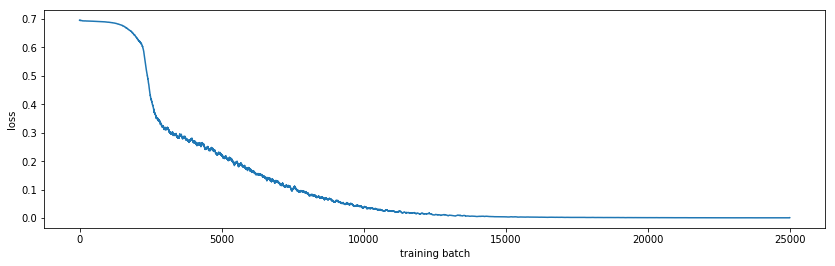

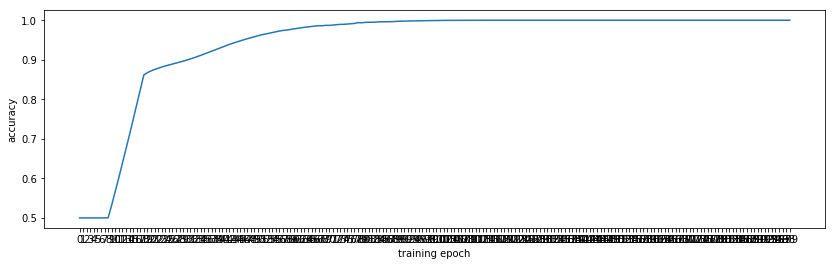

In [74]:
train_dataset, test_dataset = make_torch_train_test_datasets(ar_train, ar_test, en_train, en_test, encode_func=encode_word_onehot)
model = DNN(26*MAX_WORD_LENGTH)
losses, accuracies = train_model(model, train_dataset, num_epochs=200)
evaluate_model(model, losses, accuracies)

Train Epoch: 0 [640/8000	(8%)]	Loss: 0.682138
Train Epoch: 0 [1280/8000	(16%)]	Loss: 0.688194
Train Epoch: 0 [1920/8000	(24%)]	Loss: 0.692527
Train Epoch: 0 [2560/8000	(32%)]	Loss: 0.688031
Train Epoch: 0 [3200/8000	(40%)]	Loss: 0.697573
Train Epoch: 0 [3840/8000	(48%)]	Loss: 0.692190
Train Epoch: 0 [4480/8000	(56%)]	Loss: 0.685696
Train Epoch: 0 [5120/8000	(64%)]	Loss: 0.692087
Train Epoch: 0 [5760/8000	(72%)]	Loss: 0.692737
Train Epoch: 0 [6400/8000	(80%)]	Loss: 0.686545
Train Epoch: 0 [7040/8000	(88%)]	Loss: 0.696155
Train Epoch: 0 [7680/8000	(96%)]	Loss: 0.682638

Average loss: 0.6886, Accuracy: 4000/8000 (50%)

Train Epoch: 1 [640/8000	(8%)]	Loss: 0.693035
Train Epoch: 1 [1280/8000	(16%)]	Loss: 0.687277
Train Epoch: 1 [1920/8000	(24%)]	Loss: 0.688737
Train Epoch: 1 [2560/8000	(32%)]	Loss: 0.684771
Train Epoch: 1 [3200/8000	(40%)]	Loss: 0.679703
Train Epoch: 1 [3840/8000	(48%)]	Loss: 0.687195
Train Epoch: 1 [4480/8000	(56%)]	Loss: 0.686155
Train Epoch: 1 [5120/8000	(64%)]	Loss: 0.6

Train Epoch: 13 [3200/8000	(40%)]	Loss: 0.545976
Train Epoch: 13 [3840/8000	(48%)]	Loss: 0.608859
Train Epoch: 13 [4480/8000	(56%)]	Loss: 0.529123
Train Epoch: 13 [5120/8000	(64%)]	Loss: 0.602851
Train Epoch: 13 [5760/8000	(72%)]	Loss: 0.568282
Train Epoch: 13 [6400/8000	(80%)]	Loss: 0.452821
Train Epoch: 13 [7040/8000	(88%)]	Loss: 0.540772
Train Epoch: 13 [7680/8000	(96%)]	Loss: 0.587147

Average loss: 0.5319, Accuracy: 4000/8000 (50%)

Train Epoch: 14 [640/8000	(8%)]	Loss: 0.635108
Train Epoch: 14 [1280/8000	(16%)]	Loss: 0.461862
Train Epoch: 14 [1920/8000	(24%)]	Loss: 0.598129
Train Epoch: 14 [2560/8000	(32%)]	Loss: 0.503202
Train Epoch: 14 [3200/8000	(40%)]	Loss: 0.537638
Train Epoch: 14 [3840/8000	(48%)]	Loss: 0.553194
Train Epoch: 14 [4480/8000	(56%)]	Loss: 0.495882
Train Epoch: 14 [5120/8000	(64%)]	Loss: 0.530992
Train Epoch: 14 [5760/8000	(72%)]	Loss: 0.629223
Train Epoch: 14 [6400/8000	(80%)]	Loss: 0.513662
Train Epoch: 14 [7040/8000	(88%)]	Loss: 0.434512
Train Epoch: 14 [7680

Train Epoch: 26 [3200/8000	(40%)]	Loss: 0.516319
Train Epoch: 26 [3840/8000	(48%)]	Loss: 0.527762
Train Epoch: 26 [4480/8000	(56%)]	Loss: 0.459569
Train Epoch: 26 [5120/8000	(64%)]	Loss: 0.562589
Train Epoch: 26 [5760/8000	(72%)]	Loss: 0.570377
Train Epoch: 26 [6400/8000	(80%)]	Loss: 0.419270
Train Epoch: 26 [7040/8000	(88%)]	Loss: 0.462485
Train Epoch: 26 [7680/8000	(96%)]	Loss: 0.522715

Average loss: 0.5183, Accuracy: 4000/8000 (50%)

Train Epoch: 27 [640/8000	(8%)]	Loss: 0.518781
Train Epoch: 27 [1280/8000	(16%)]	Loss: 0.436178
Train Epoch: 27 [1920/8000	(24%)]	Loss: 0.553635
Train Epoch: 27 [2560/8000	(32%)]	Loss: 0.563758
Train Epoch: 27 [3200/8000	(40%)]	Loss: 0.524197
Train Epoch: 27 [3840/8000	(48%)]	Loss: 0.554082
Train Epoch: 27 [4480/8000	(56%)]	Loss: 0.517693
Train Epoch: 27 [5120/8000	(64%)]	Loss: 0.489900
Train Epoch: 27 [5760/8000	(72%)]	Loss: 0.568984
Train Epoch: 27 [6400/8000	(80%)]	Loss: 0.443845
Train Epoch: 27 [7040/8000	(88%)]	Loss: 0.444175
Train Epoch: 27 [7680

Train Epoch: 39 [3200/8000	(40%)]	Loss: 0.521447
Train Epoch: 39 [3840/8000	(48%)]	Loss: 0.469378
Train Epoch: 39 [4480/8000	(56%)]	Loss: 0.440784
Train Epoch: 39 [5120/8000	(64%)]	Loss: 0.534213
Train Epoch: 39 [5760/8000	(72%)]	Loss: 0.567494
Train Epoch: 39 [6400/8000	(80%)]	Loss: 0.447617
Train Epoch: 39 [7040/8000	(88%)]	Loss: 0.555242
Train Epoch: 39 [7680/8000	(96%)]	Loss: 0.500868

Average loss: 0.5086, Accuracy: 4000/8000 (50%)

Train Epoch: 40 [640/8000	(8%)]	Loss: 0.532402
Train Epoch: 40 [1280/8000	(16%)]	Loss: 0.512129
Train Epoch: 40 [1920/8000	(24%)]	Loss: 0.473502
Train Epoch: 40 [2560/8000	(32%)]	Loss: 0.451932
Train Epoch: 40 [3200/8000	(40%)]	Loss: 0.490640
Train Epoch: 40 [3840/8000	(48%)]	Loss: 0.455546
Train Epoch: 40 [4480/8000	(56%)]	Loss: 0.533817
Train Epoch: 40 [5120/8000	(64%)]	Loss: 0.543228
Train Epoch: 40 [5760/8000	(72%)]	Loss: 0.538082
Train Epoch: 40 [6400/8000	(80%)]	Loss: 0.448728
Train Epoch: 40 [7040/8000	(88%)]	Loss: 0.494539
Train Epoch: 40 [7680

Train Epoch: 52 [3200/8000	(40%)]	Loss: 0.508956
Train Epoch: 52 [3840/8000	(48%)]	Loss: 0.560418
Train Epoch: 52 [4480/8000	(56%)]	Loss: 0.611809
Train Epoch: 52 [5120/8000	(64%)]	Loss: 0.491680
Train Epoch: 52 [5760/8000	(72%)]	Loss: 0.472251
Train Epoch: 52 [6400/8000	(80%)]	Loss: 0.468409
Train Epoch: 52 [7040/8000	(88%)]	Loss: 0.522367
Train Epoch: 52 [7680/8000	(96%)]	Loss: 0.499488

Average loss: 0.4989, Accuracy: 4000/8000 (50%)

Train Epoch: 53 [640/8000	(8%)]	Loss: 0.472356
Train Epoch: 53 [1280/8000	(16%)]	Loss: 0.450475
Train Epoch: 53 [1920/8000	(24%)]	Loss: 0.455338
Train Epoch: 53 [2560/8000	(32%)]	Loss: 0.498584
Train Epoch: 53 [3200/8000	(40%)]	Loss: 0.588188
Train Epoch: 53 [3840/8000	(48%)]	Loss: 0.530739
Train Epoch: 53 [4480/8000	(56%)]	Loss: 0.475860
Train Epoch: 53 [5120/8000	(64%)]	Loss: 0.453404
Train Epoch: 53 [5760/8000	(72%)]	Loss: 0.528270
Train Epoch: 53 [6400/8000	(80%)]	Loss: 0.638746
Train Epoch: 53 [7040/8000	(88%)]	Loss: 0.604670
Train Epoch: 53 [7680

Train Epoch: 65 [3200/8000	(40%)]	Loss: 0.455473
Train Epoch: 65 [3840/8000	(48%)]	Loss: 0.490178
Train Epoch: 65 [4480/8000	(56%)]	Loss: 0.455851
Train Epoch: 65 [5120/8000	(64%)]	Loss: 0.564853
Train Epoch: 65 [5760/8000	(72%)]	Loss: 0.503548
Train Epoch: 65 [6400/8000	(80%)]	Loss: 0.461606
Train Epoch: 65 [7040/8000	(88%)]	Loss: 0.543382
Train Epoch: 65 [7680/8000	(96%)]	Loss: 0.567054

Average loss: 0.4905, Accuracy: 4000/8000 (50%)

Train Epoch: 66 [640/8000	(8%)]	Loss: 0.491137
Train Epoch: 66 [1280/8000	(16%)]	Loss: 0.467672
Train Epoch: 66 [1920/8000	(24%)]	Loss: 0.521103
Train Epoch: 66 [2560/8000	(32%)]	Loss: 0.505202
Train Epoch: 66 [3200/8000	(40%)]	Loss: 0.477299
Train Epoch: 66 [3840/8000	(48%)]	Loss: 0.422674
Train Epoch: 66 [4480/8000	(56%)]	Loss: 0.555666
Train Epoch: 66 [5120/8000	(64%)]	Loss: 0.495453
Train Epoch: 66 [5760/8000	(72%)]	Loss: 0.465628
Train Epoch: 66 [6400/8000	(80%)]	Loss: 0.395451
Train Epoch: 66 [7040/8000	(88%)]	Loss: 0.467307
Train Epoch: 66 [7680

Train Epoch: 78 [3200/8000	(40%)]	Loss: 0.531746
Train Epoch: 78 [3840/8000	(48%)]	Loss: 0.450632
Train Epoch: 78 [4480/8000	(56%)]	Loss: 0.587203
Train Epoch: 78 [5120/8000	(64%)]	Loss: 0.508129
Train Epoch: 78 [5760/8000	(72%)]	Loss: 0.494709
Train Epoch: 78 [6400/8000	(80%)]	Loss: 0.445636
Train Epoch: 78 [7040/8000	(88%)]	Loss: 0.483362
Train Epoch: 78 [7680/8000	(96%)]	Loss: 0.527698

Average loss: 0.4834, Accuracy: 4002/8000 (50%)

Train Epoch: 79 [640/8000	(8%)]	Loss: 0.405360
Train Epoch: 79 [1280/8000	(16%)]	Loss: 0.449010
Train Epoch: 79 [1920/8000	(24%)]	Loss: 0.371029
Train Epoch: 79 [2560/8000	(32%)]	Loss: 0.522992
Train Epoch: 79 [3200/8000	(40%)]	Loss: 0.543229
Train Epoch: 79 [3840/8000	(48%)]	Loss: 0.515267
Train Epoch: 79 [4480/8000	(56%)]	Loss: 0.475317
Train Epoch: 79 [5120/8000	(64%)]	Loss: 0.597187
Train Epoch: 79 [5760/8000	(72%)]	Loss: 0.485498
Train Epoch: 79 [6400/8000	(80%)]	Loss: 0.536287
Train Epoch: 79 [7040/8000	(88%)]	Loss: 0.548468
Train Epoch: 79 [7680

Train Epoch: 91 [3200/8000	(40%)]	Loss: 0.246245
Train Epoch: 91 [3840/8000	(48%)]	Loss: 0.209532
Train Epoch: 91 [4480/8000	(56%)]	Loss: 0.267980
Train Epoch: 91 [5120/8000	(64%)]	Loss: 0.204801
Train Epoch: 91 [5760/8000	(72%)]	Loss: 0.240603
Train Epoch: 91 [6400/8000	(80%)]	Loss: 0.293617
Train Epoch: 91 [7040/8000	(88%)]	Loss: 0.278425
Train Epoch: 91 [7680/8000	(96%)]	Loss: 0.261247

Average loss: 0.2583, Accuracy: 7173/8000 (90%)

Train Epoch: 92 [640/8000	(8%)]	Loss: 0.174138
Train Epoch: 92 [1280/8000	(16%)]	Loss: 0.214364
Train Epoch: 92 [1920/8000	(24%)]	Loss: 0.301494
Train Epoch: 92 [2560/8000	(32%)]	Loss: 0.146444
Train Epoch: 92 [3200/8000	(40%)]	Loss: 0.198637
Train Epoch: 92 [3840/8000	(48%)]	Loss: 0.253982
Train Epoch: 92 [4480/8000	(56%)]	Loss: 0.288588
Train Epoch: 92 [5120/8000	(64%)]	Loss: 0.366883
Train Epoch: 92 [5760/8000	(72%)]	Loss: 0.275297
Train Epoch: 92 [6400/8000	(80%)]	Loss: 0.289699
Train Epoch: 92 [7040/8000	(88%)]	Loss: 0.171610
Train Epoch: 92 [7680

Train Epoch: 104 [3200/8000	(40%)]	Loss: 0.198054
Train Epoch: 104 [3840/8000	(48%)]	Loss: 0.407026
Train Epoch: 104 [4480/8000	(56%)]	Loss: 0.163933
Train Epoch: 104 [5120/8000	(64%)]	Loss: 0.179223
Train Epoch: 104 [5760/8000	(72%)]	Loss: 0.194479
Train Epoch: 104 [6400/8000	(80%)]	Loss: 0.248934
Train Epoch: 104 [7040/8000	(88%)]	Loss: 0.362576
Train Epoch: 104 [7680/8000	(96%)]	Loss: 0.214924

Average loss: 0.2424, Accuracy: 7216/8000 (90%)

Train Epoch: 105 [640/8000	(8%)]	Loss: 0.306627
Train Epoch: 105 [1280/8000	(16%)]	Loss: 0.297700
Train Epoch: 105 [1920/8000	(24%)]	Loss: 0.236359
Train Epoch: 105 [2560/8000	(32%)]	Loss: 0.285549
Train Epoch: 105 [3200/8000	(40%)]	Loss: 0.353680
Train Epoch: 105 [3840/8000	(48%)]	Loss: 0.132607
Train Epoch: 105 [4480/8000	(56%)]	Loss: 0.207088
Train Epoch: 105 [5120/8000	(64%)]	Loss: 0.182894
Train Epoch: 105 [5760/8000	(72%)]	Loss: 0.185154
Train Epoch: 105 [6400/8000	(80%)]	Loss: 0.243053
Train Epoch: 105 [7040/8000	(88%)]	Loss: 0.176309
Tr

Train Epoch: 117 [3840/8000	(48%)]	Loss: 0.275792
Train Epoch: 117 [4480/8000	(56%)]	Loss: 0.404469
Train Epoch: 117 [5120/8000	(64%)]	Loss: 0.246555
Train Epoch: 117 [5760/8000	(72%)]	Loss: 0.278464
Train Epoch: 117 [6400/8000	(80%)]	Loss: 0.151962
Train Epoch: 117 [7040/8000	(88%)]	Loss: 0.223000
Train Epoch: 117 [7680/8000	(96%)]	Loss: 0.203740

Average loss: 0.2270, Accuracy: 7245/8000 (91%)

Train Epoch: 118 [640/8000	(8%)]	Loss: 0.165164
Train Epoch: 118 [1280/8000	(16%)]	Loss: 0.310626
Train Epoch: 118 [1920/8000	(24%)]	Loss: 0.154718
Train Epoch: 118 [2560/8000	(32%)]	Loss: 0.254614
Train Epoch: 118 [3200/8000	(40%)]	Loss: 0.290877
Train Epoch: 118 [3840/8000	(48%)]	Loss: 0.202911
Train Epoch: 118 [4480/8000	(56%)]	Loss: 0.244745
Train Epoch: 118 [5120/8000	(64%)]	Loss: 0.221392
Train Epoch: 118 [5760/8000	(72%)]	Loss: 0.142066
Train Epoch: 118 [6400/8000	(80%)]	Loss: 0.332408
Train Epoch: 118 [7040/8000	(88%)]	Loss: 0.135479
Train Epoch: 118 [7680/8000	(96%)]	Loss: 0.279326

A

Train Epoch: 130 [3200/8000	(40%)]	Loss: 0.245740
Train Epoch: 130 [3840/8000	(48%)]	Loss: 0.158402
Train Epoch: 130 [4480/8000	(56%)]	Loss: 0.138548
Train Epoch: 130 [5120/8000	(64%)]	Loss: 0.203705
Train Epoch: 130 [5760/8000	(72%)]	Loss: 0.206426
Train Epoch: 130 [6400/8000	(80%)]	Loss: 0.173591
Train Epoch: 130 [7040/8000	(88%)]	Loss: 0.309497
Train Epoch: 130 [7680/8000	(96%)]	Loss: 0.222067

Average loss: 0.2133, Accuracy: 7330/8000 (92%)

Train Epoch: 131 [640/8000	(8%)]	Loss: 0.162844
Train Epoch: 131 [1280/8000	(16%)]	Loss: 0.223254
Train Epoch: 131 [1920/8000	(24%)]	Loss: 0.175110
Train Epoch: 131 [2560/8000	(32%)]	Loss: 0.198429
Train Epoch: 131 [3200/8000	(40%)]	Loss: 0.402916
Train Epoch: 131 [3840/8000	(48%)]	Loss: 0.301605
Train Epoch: 131 [4480/8000	(56%)]	Loss: 0.311007
Train Epoch: 131 [5120/8000	(64%)]	Loss: 0.219242
Train Epoch: 131 [5760/8000	(72%)]	Loss: 0.155689
Train Epoch: 131 [6400/8000	(80%)]	Loss: 0.277239
Train Epoch: 131 [7040/8000	(88%)]	Loss: 0.137484
Tr

Train Epoch: 143 [3200/8000	(40%)]	Loss: 0.291425
Train Epoch: 143 [3840/8000	(48%)]	Loss: 0.176753
Train Epoch: 143 [4480/8000	(56%)]	Loss: 0.384513
Train Epoch: 143 [5120/8000	(64%)]	Loss: 0.137602
Train Epoch: 143 [5760/8000	(72%)]	Loss: 0.177801
Train Epoch: 143 [6400/8000	(80%)]	Loss: 0.266041
Train Epoch: 143 [7040/8000	(88%)]	Loss: 0.228037
Train Epoch: 143 [7680/8000	(96%)]	Loss: 0.179633

Average loss: 0.1989, Accuracy: 7369/8000 (92%)

Train Epoch: 144 [640/8000	(8%)]	Loss: 0.154354
Train Epoch: 144 [1280/8000	(16%)]	Loss: 0.328670
Train Epoch: 144 [1920/8000	(24%)]	Loss: 0.190187
Train Epoch: 144 [2560/8000	(32%)]	Loss: 0.294102
Train Epoch: 144 [3200/8000	(40%)]	Loss: 0.240137
Train Epoch: 144 [3840/8000	(48%)]	Loss: 0.223165
Train Epoch: 144 [4480/8000	(56%)]	Loss: 0.404475
Train Epoch: 144 [5120/8000	(64%)]	Loss: 0.133838
Train Epoch: 144 [5760/8000	(72%)]	Loss: 0.273451
Train Epoch: 144 [6400/8000	(80%)]	Loss: 0.152614
Train Epoch: 144 [7040/8000	(88%)]	Loss: 0.205060
Tr

Train Epoch: 156 [3200/8000	(40%)]	Loss: 0.288644
Train Epoch: 156 [3840/8000	(48%)]	Loss: 0.315390
Train Epoch: 156 [4480/8000	(56%)]	Loss: 0.232897
Train Epoch: 156 [5120/8000	(64%)]	Loss: 0.229706
Train Epoch: 156 [5760/8000	(72%)]	Loss: 0.146214
Train Epoch: 156 [6400/8000	(80%)]	Loss: 0.121302
Train Epoch: 156 [7040/8000	(88%)]	Loss: 0.233616
Train Epoch: 156 [7680/8000	(96%)]	Loss: 0.203273

Average loss: 0.2098, Accuracy: 7303/8000 (91%)

Train Epoch: 157 [640/8000	(8%)]	Loss: 0.172145
Train Epoch: 157 [1280/8000	(16%)]	Loss: 0.179542
Train Epoch: 157 [1920/8000	(24%)]	Loss: 0.233755
Train Epoch: 157 [2560/8000	(32%)]	Loss: 0.214230
Train Epoch: 157 [3200/8000	(40%)]	Loss: 0.184686
Train Epoch: 157 [3840/8000	(48%)]	Loss: 0.131502
Train Epoch: 157 [4480/8000	(56%)]	Loss: 0.228595
Train Epoch: 157 [5120/8000	(64%)]	Loss: 0.142416
Train Epoch: 157 [5760/8000	(72%)]	Loss: 0.242119
Train Epoch: 157 [6400/8000	(80%)]	Loss: 0.185776
Train Epoch: 157 [7040/8000	(88%)]	Loss: 0.176033
Tr

Train Epoch: 169 [3200/8000	(40%)]	Loss: 0.222813
Train Epoch: 169 [3840/8000	(48%)]	Loss: 0.163785
Train Epoch: 169 [4480/8000	(56%)]	Loss: 0.178296
Train Epoch: 169 [5120/8000	(64%)]	Loss: 0.129947
Train Epoch: 169 [5760/8000	(72%)]	Loss: 0.216965
Train Epoch: 169 [6400/8000	(80%)]	Loss: 0.155549
Train Epoch: 169 [7040/8000	(88%)]	Loss: 0.164000
Train Epoch: 169 [7680/8000	(96%)]	Loss: 0.079471

Average loss: 0.1955, Accuracy: 7357/8000 (92%)

Train Epoch: 170 [640/8000	(8%)]	Loss: 0.210092
Train Epoch: 170 [1280/8000	(16%)]	Loss: 0.110631
Train Epoch: 170 [1920/8000	(24%)]	Loss: 0.233335
Train Epoch: 170 [2560/8000	(32%)]	Loss: 0.175360
Train Epoch: 170 [3200/8000	(40%)]	Loss: 0.131153
Train Epoch: 170 [3840/8000	(48%)]	Loss: 0.070143
Train Epoch: 170 [4480/8000	(56%)]	Loss: 0.152459
Train Epoch: 170 [5120/8000	(64%)]	Loss: 0.177305
Train Epoch: 170 [5760/8000	(72%)]	Loss: 0.264738
Train Epoch: 170 [6400/8000	(80%)]	Loss: 0.212513
Train Epoch: 170 [7040/8000	(88%)]	Loss: 0.190091
Tr

Train Epoch: 182 [3200/8000	(40%)]	Loss: 0.165226
Train Epoch: 182 [3840/8000	(48%)]	Loss: 0.220548
Train Epoch: 182 [4480/8000	(56%)]	Loss: 0.200930
Train Epoch: 182 [5120/8000	(64%)]	Loss: 0.191575
Train Epoch: 182 [5760/8000	(72%)]	Loss: 0.296147
Train Epoch: 182 [6400/8000	(80%)]	Loss: 0.314146
Train Epoch: 182 [7040/8000	(88%)]	Loss: 0.212312
Train Epoch: 182 [7680/8000	(96%)]	Loss: 0.199471

Average loss: 0.1735, Accuracy: 7451/8000 (93%)

Train Epoch: 183 [640/8000	(8%)]	Loss: 0.149767
Train Epoch: 183 [1280/8000	(16%)]	Loss: 0.216051
Train Epoch: 183 [1920/8000	(24%)]	Loss: 0.151265
Train Epoch: 183 [2560/8000	(32%)]	Loss: 0.166112
Train Epoch: 183 [3200/8000	(40%)]	Loss: 0.148877
Train Epoch: 183 [3840/8000	(48%)]	Loss: 0.132913
Train Epoch: 183 [4480/8000	(56%)]	Loss: 0.165008
Train Epoch: 183 [5120/8000	(64%)]	Loss: 0.377115
Train Epoch: 183 [5760/8000	(72%)]	Loss: 0.193348
Train Epoch: 183 [6400/8000	(80%)]	Loss: 0.183685
Train Epoch: 183 [7040/8000	(88%)]	Loss: 0.152612
Tr

Train Epoch: 195 [3200/8000	(40%)]	Loss: 0.305774
Train Epoch: 195 [3840/8000	(48%)]	Loss: 0.146321
Train Epoch: 195 [4480/8000	(56%)]	Loss: 0.195634
Train Epoch: 195 [5120/8000	(64%)]	Loss: 0.147250
Train Epoch: 195 [5760/8000	(72%)]	Loss: 0.069379
Train Epoch: 195 [6400/8000	(80%)]	Loss: 0.118191
Train Epoch: 195 [7040/8000	(88%)]	Loss: 0.118888
Train Epoch: 195 [7680/8000	(96%)]	Loss: 0.296835

Average loss: 0.1621, Accuracy: 7516/8000 (94%)

Train Epoch: 196 [640/8000	(8%)]	Loss: 0.177983
Train Epoch: 196 [1280/8000	(16%)]	Loss: 0.234336
Train Epoch: 196 [1920/8000	(24%)]	Loss: 0.374177
Train Epoch: 196 [2560/8000	(32%)]	Loss: 0.120080
Train Epoch: 196 [3200/8000	(40%)]	Loss: 0.239356
Train Epoch: 196 [3840/8000	(48%)]	Loss: 0.146216
Train Epoch: 196 [4480/8000	(56%)]	Loss: 0.103845
Train Epoch: 196 [5120/8000	(64%)]	Loss: 0.186001
Train Epoch: 196 [5760/8000	(72%)]	Loss: 0.145051
Train Epoch: 196 [6400/8000	(80%)]	Loss: 0.145364
Train Epoch: 196 [7040/8000	(88%)]	Loss: 0.116813
Tr

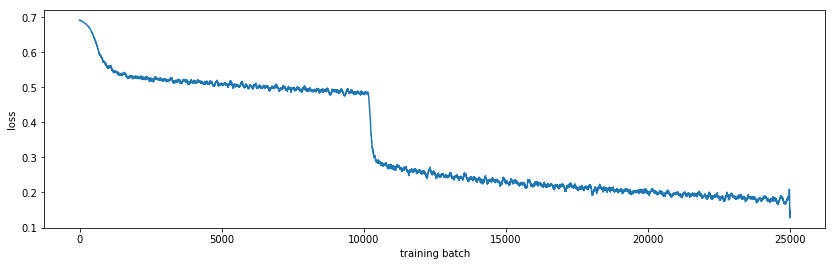

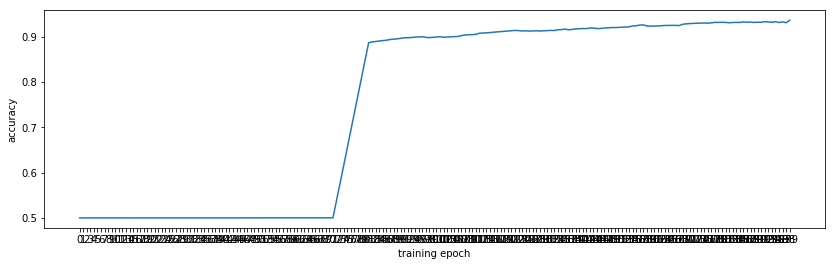

In [77]:
train_dataset, test_dataset = make_torch_train_test_datasets(ar_train, ar_test, en_train, en_test, encode_func=encode_word_bag)
model = DNN(26)
losses, accuracies = train_model(model, train_dataset, num_epochs=200)
evaluate_model(model, losses, accuracies)

Train Epoch: 0 [640/8000	(8%)]	Loss: 0.693740
Train Epoch: 0 [1280/8000	(16%)]	Loss: 0.692084
Train Epoch: 0 [1920/8000	(24%)]	Loss: 0.692408
Train Epoch: 0 [2560/8000	(32%)]	Loss: 0.690915
Train Epoch: 0 [3200/8000	(40%)]	Loss: 0.691009
Train Epoch: 0 [3840/8000	(48%)]	Loss: 0.688374
Train Epoch: 0 [4480/8000	(56%)]	Loss: 0.689477
Train Epoch: 0 [5120/8000	(64%)]	Loss: 0.687611
Train Epoch: 0 [5760/8000	(72%)]	Loss: 0.688365
Train Epoch: 0 [6400/8000	(80%)]	Loss: 0.689472
Train Epoch: 0 [7040/8000	(88%)]	Loss: 0.684321
Train Epoch: 0 [7680/8000	(96%)]	Loss: 0.666762

Average loss: 0.6815, Accuracy: 5070/8000 (63%)

Train Epoch: 1 [640/8000	(8%)]	Loss: 0.687739
Train Epoch: 1 [1280/8000	(16%)]	Loss: 0.682515
Train Epoch: 1 [1920/8000	(24%)]	Loss: 0.672848
Train Epoch: 1 [2560/8000	(32%)]	Loss: 0.681563
Train Epoch: 1 [3200/8000	(40%)]	Loss: 0.673176
Train Epoch: 1 [3840/8000	(48%)]	Loss: 0.670143
Train Epoch: 1 [4480/8000	(56%)]	Loss: 0.658919
Train Epoch: 1 [5120/8000	(64%)]	Loss: 0.6

Train Epoch: 13 [1280/8000	(16%)]	Loss: 0.415089
Train Epoch: 13 [1920/8000	(24%)]	Loss: 0.374470
Train Epoch: 13 [2560/8000	(32%)]	Loss: 0.373948
Train Epoch: 13 [3200/8000	(40%)]	Loss: 0.375596
Train Epoch: 13 [3840/8000	(48%)]	Loss: 0.388185
Train Epoch: 13 [4480/8000	(56%)]	Loss: 0.398930
Train Epoch: 13 [5120/8000	(64%)]	Loss: 0.301423
Train Epoch: 13 [5760/8000	(72%)]	Loss: 0.280847
Train Epoch: 13 [6400/8000	(80%)]	Loss: 0.293264
Train Epoch: 13 [7040/8000	(88%)]	Loss: 0.308468
Train Epoch: 13 [7680/8000	(96%)]	Loss: 0.436285

Average loss: 0.3261, Accuracy: 6902/8000 (86%)

Train Epoch: 14 [640/8000	(8%)]	Loss: 0.338136
Train Epoch: 14 [1280/8000	(16%)]	Loss: 0.421723
Train Epoch: 14 [1920/8000	(24%)]	Loss: 0.312268
Train Epoch: 14 [2560/8000	(32%)]	Loss: 0.328508
Train Epoch: 14 [3200/8000	(40%)]	Loss: 0.277525
Train Epoch: 14 [3840/8000	(48%)]	Loss: 0.301784
Train Epoch: 14 [4480/8000	(56%)]	Loss: 0.365833
Train Epoch: 14 [5120/8000	(64%)]	Loss: 0.385299
Train Epoch: 14 [5760

Train Epoch: 26 [640/8000	(8%)]	Loss: 0.331760
Train Epoch: 26 [1280/8000	(16%)]	Loss: 0.196163
Train Epoch: 26 [1920/8000	(24%)]	Loss: 0.205575
Train Epoch: 26 [2560/8000	(32%)]	Loss: 0.262376
Train Epoch: 26 [3200/8000	(40%)]	Loss: 0.362092
Train Epoch: 26 [3840/8000	(48%)]	Loss: 0.234263
Train Epoch: 26 [4480/8000	(56%)]	Loss: 0.180186
Train Epoch: 26 [5120/8000	(64%)]	Loss: 0.339289
Train Epoch: 26 [5760/8000	(72%)]	Loss: 0.156807
Train Epoch: 26 [6400/8000	(80%)]	Loss: 0.210183
Train Epoch: 26 [7040/8000	(88%)]	Loss: 0.131372
Train Epoch: 26 [7680/8000	(96%)]	Loss: 0.212242

Average loss: 0.2378, Accuracy: 7214/8000 (90%)

Train Epoch: 27 [640/8000	(8%)]	Loss: 0.216527
Train Epoch: 27 [1280/8000	(16%)]	Loss: 0.202270
Train Epoch: 27 [1920/8000	(24%)]	Loss: 0.153142
Train Epoch: 27 [2560/8000	(32%)]	Loss: 0.296044
Train Epoch: 27 [3200/8000	(40%)]	Loss: 0.193299
Train Epoch: 27 [3840/8000	(48%)]	Loss: 0.185945
Train Epoch: 27 [4480/8000	(56%)]	Loss: 0.195078
Train Epoch: 27 [5120/8


Average loss: 0.1789, Accuracy: 7448/8000 (93%)

Train Epoch: 39 [640/8000	(8%)]	Loss: 0.203542
Train Epoch: 39 [1280/8000	(16%)]	Loss: 0.196593
Train Epoch: 39 [1920/8000	(24%)]	Loss: 0.230985
Train Epoch: 39 [2560/8000	(32%)]	Loss: 0.145792
Train Epoch: 39 [3200/8000	(40%)]	Loss: 0.191811
Train Epoch: 39 [3840/8000	(48%)]	Loss: 0.256563
Train Epoch: 39 [4480/8000	(56%)]	Loss: 0.130331
Train Epoch: 39 [5120/8000	(64%)]	Loss: 0.228833
Train Epoch: 39 [5760/8000	(72%)]	Loss: 0.170149
Train Epoch: 39 [6400/8000	(80%)]	Loss: 0.152136
Train Epoch: 39 [7040/8000	(88%)]	Loss: 0.257598
Train Epoch: 39 [7680/8000	(96%)]	Loss: 0.258988

Average loss: 0.1730, Accuracy: 7474/8000 (93%)

Train Epoch: 40 [640/8000	(8%)]	Loss: 0.156700
Train Epoch: 40 [1280/8000	(16%)]	Loss: 0.295770
Train Epoch: 40 [1920/8000	(24%)]	Loss: 0.197462
Train Epoch: 40 [2560/8000	(32%)]	Loss: 0.146880
Train Epoch: 40 [3200/8000	(40%)]	Loss: 0.170071
Train Epoch: 40 [3840/8000	(48%)]	Loss: 0.156651
Train Epoch: 40 [4480/

Train Epoch: 51 [7680/8000	(96%)]	Loss: 0.187631

Average loss: 0.1883, Accuracy: 7333/8000 (92%)

Train Epoch: 52 [640/8000	(8%)]	Loss: 0.146994
Train Epoch: 52 [1280/8000	(16%)]	Loss: 0.109947
Train Epoch: 52 [1920/8000	(24%)]	Loss: 0.271528
Train Epoch: 52 [2560/8000	(32%)]	Loss: 0.084789
Train Epoch: 52 [3200/8000	(40%)]	Loss: 0.115190
Train Epoch: 52 [3840/8000	(48%)]	Loss: 0.150769
Train Epoch: 52 [4480/8000	(56%)]	Loss: 0.147818
Train Epoch: 52 [5120/8000	(64%)]	Loss: 0.220477
Train Epoch: 52 [5760/8000	(72%)]	Loss: 0.082404
Train Epoch: 52 [6400/8000	(80%)]	Loss: 0.087852
Train Epoch: 52 [7040/8000	(88%)]	Loss: 0.243114
Train Epoch: 52 [7680/8000	(96%)]	Loss: 0.158498

Average loss: 0.1457, Accuracy: 7550/8000 (94%)

Train Epoch: 53 [640/8000	(8%)]	Loss: 0.138324
Train Epoch: 53 [1280/8000	(16%)]	Loss: 0.230776
Train Epoch: 53 [1920/8000	(24%)]	Loss: 0.194059
Train Epoch: 53 [2560/8000	(32%)]	Loss: 0.207189
Train Epoch: 53 [3200/8000	(40%)]	Loss: 0.139168
Train Epoch: 53 [3840/

Train Epoch: 64 [7040/8000	(88%)]	Loss: 0.074261
Train Epoch: 64 [7680/8000	(96%)]	Loss: 0.156340

Average loss: 0.1096, Accuracy: 7672/8000 (96%)

Train Epoch: 65 [640/8000	(8%)]	Loss: 0.214999
Train Epoch: 65 [1280/8000	(16%)]	Loss: 0.063717
Train Epoch: 65 [1920/8000	(24%)]	Loss: 0.065337
Train Epoch: 65 [2560/8000	(32%)]	Loss: 0.042158
Train Epoch: 65 [3200/8000	(40%)]	Loss: 0.131493
Train Epoch: 65 [3840/8000	(48%)]	Loss: 0.057317
Train Epoch: 65 [4480/8000	(56%)]	Loss: 0.218065
Train Epoch: 65 [5120/8000	(64%)]	Loss: 0.207560
Train Epoch: 65 [5760/8000	(72%)]	Loss: 0.066845
Train Epoch: 65 [6400/8000	(80%)]	Loss: 0.140608
Train Epoch: 65 [7040/8000	(88%)]	Loss: 0.087477
Train Epoch: 65 [7680/8000	(96%)]	Loss: 0.191223

Average loss: 0.1238, Accuracy: 7591/8000 (95%)

Train Epoch: 66 [640/8000	(8%)]	Loss: 0.099570
Train Epoch: 66 [1280/8000	(16%)]	Loss: 0.120651
Train Epoch: 66 [1920/8000	(24%)]	Loss: 0.061670
Train Epoch: 66 [2560/8000	(32%)]	Loss: 0.118829
Train Epoch: 66 [3200/

Train Epoch: 77 [6400/8000	(80%)]	Loss: 0.108695
Train Epoch: 77 [7040/8000	(88%)]	Loss: 0.152262
Train Epoch: 77 [7680/8000	(96%)]	Loss: 0.182020

Average loss: 0.0844, Accuracy: 7753/8000 (97%)

Train Epoch: 78 [640/8000	(8%)]	Loss: 0.112937
Train Epoch: 78 [1280/8000	(16%)]	Loss: 0.077792
Train Epoch: 78 [1920/8000	(24%)]	Loss: 0.145391
Train Epoch: 78 [2560/8000	(32%)]	Loss: 0.246108
Train Epoch: 78 [3200/8000	(40%)]	Loss: 0.109240
Train Epoch: 78 [3840/8000	(48%)]	Loss: 0.108744
Train Epoch: 78 [4480/8000	(56%)]	Loss: 0.071010
Train Epoch: 78 [5120/8000	(64%)]	Loss: 0.103232
Train Epoch: 78 [5760/8000	(72%)]	Loss: 0.106322
Train Epoch: 78 [6400/8000	(80%)]	Loss: 0.112861
Train Epoch: 78 [7040/8000	(88%)]	Loss: 0.056347
Train Epoch: 78 [7680/8000	(96%)]	Loss: 0.050819

Average loss: 0.0816, Accuracy: 7760/8000 (97%)

Train Epoch: 79 [640/8000	(8%)]	Loss: 0.108629
Train Epoch: 79 [1280/8000	(16%)]	Loss: 0.098306
Train Epoch: 79 [1920/8000	(24%)]	Loss: 0.108571
Train Epoch: 79 [2560/

Train Epoch: 90 [5760/8000	(72%)]	Loss: 0.095442
Train Epoch: 90 [6400/8000	(80%)]	Loss: 0.036044
Train Epoch: 90 [7040/8000	(88%)]	Loss: 0.033338
Train Epoch: 90 [7680/8000	(96%)]	Loss: 0.163913

Average loss: 0.0650, Accuracy: 7827/8000 (98%)

Train Epoch: 91 [640/8000	(8%)]	Loss: 0.094197
Train Epoch: 91 [1280/8000	(16%)]	Loss: 0.025454
Train Epoch: 91 [1920/8000	(24%)]	Loss: 0.061362
Train Epoch: 91 [2560/8000	(32%)]	Loss: 0.086001
Train Epoch: 91 [3200/8000	(40%)]	Loss: 0.042054
Train Epoch: 91 [3840/8000	(48%)]	Loss: 0.050045
Train Epoch: 91 [4480/8000	(56%)]	Loss: 0.030906
Train Epoch: 91 [5120/8000	(64%)]	Loss: 0.083553
Train Epoch: 91 [5760/8000	(72%)]	Loss: 0.059118
Train Epoch: 91 [6400/8000	(80%)]	Loss: 0.095809
Train Epoch: 91 [7040/8000	(88%)]	Loss: 0.074159
Train Epoch: 91 [7680/8000	(96%)]	Loss: 0.019676

Average loss: 0.0549, Accuracy: 7862/8000 (98%)

Train Epoch: 92 [640/8000	(8%)]	Loss: 0.072437
Train Epoch: 92 [1280/8000	(16%)]	Loss: 0.021322
Train Epoch: 92 [1920/

Train Epoch: 103 [4480/8000	(56%)]	Loss: 0.058310
Train Epoch: 103 [5120/8000	(64%)]	Loss: 0.040221
Train Epoch: 103 [5760/8000	(72%)]	Loss: 0.028871
Train Epoch: 103 [6400/8000	(80%)]	Loss: 0.024691
Train Epoch: 103 [7040/8000	(88%)]	Loss: 0.153265
Train Epoch: 103 [7680/8000	(96%)]	Loss: 0.110227

Average loss: 0.0730, Accuracy: 7764/8000 (97%)

Train Epoch: 104 [640/8000	(8%)]	Loss: 0.062896
Train Epoch: 104 [1280/8000	(16%)]	Loss: 0.013396
Train Epoch: 104 [1920/8000	(24%)]	Loss: 0.024351
Train Epoch: 104 [2560/8000	(32%)]	Loss: 0.039218
Train Epoch: 104 [3200/8000	(40%)]	Loss: 0.027110
Train Epoch: 104 [3840/8000	(48%)]	Loss: 0.051802
Train Epoch: 104 [4480/8000	(56%)]	Loss: 0.035581
Train Epoch: 104 [5120/8000	(64%)]	Loss: 0.122733
Train Epoch: 104 [5760/8000	(72%)]	Loss: 0.050505
Train Epoch: 104 [6400/8000	(80%)]	Loss: 0.098401
Train Epoch: 104 [7040/8000	(88%)]	Loss: 0.128316
Train Epoch: 104 [7680/8000	(96%)]	Loss: 0.158811

Average loss: 0.0473, Accuracy: 7884/8000 (99%)

Tr

Train Epoch: 116 [1920/8000	(24%)]	Loss: 0.023011
Train Epoch: 116 [2560/8000	(32%)]	Loss: 0.106194
Train Epoch: 116 [3200/8000	(40%)]	Loss: 0.064771
Train Epoch: 116 [3840/8000	(48%)]	Loss: 0.024600
Train Epoch: 116 [4480/8000	(56%)]	Loss: 0.050616
Train Epoch: 116 [5120/8000	(64%)]	Loss: 0.022955
Train Epoch: 116 [5760/8000	(72%)]	Loss: 0.029592
Train Epoch: 116 [6400/8000	(80%)]	Loss: 0.198203
Train Epoch: 116 [7040/8000	(88%)]	Loss: 0.271347
Train Epoch: 116 [7680/8000	(96%)]	Loss: 0.022293

Average loss: 0.0443, Accuracy: 7865/8000 (98%)

Train Epoch: 117 [640/8000	(8%)]	Loss: 0.038136
Train Epoch: 117 [1280/8000	(16%)]	Loss: 0.118695
Train Epoch: 117 [1920/8000	(24%)]	Loss: 0.020912
Train Epoch: 117 [2560/8000	(32%)]	Loss: 0.036419
Train Epoch: 117 [3200/8000	(40%)]	Loss: 0.034008
Train Epoch: 117 [3840/8000	(48%)]	Loss: 0.043855
Train Epoch: 117 [4480/8000	(56%)]	Loss: 0.074252
Train Epoch: 117 [5120/8000	(64%)]	Loss: 0.051363
Train Epoch: 117 [5760/8000	(72%)]	Loss: 0.046447
Tr

Train Epoch: 128 [7680/8000	(96%)]	Loss: 0.019493

Average loss: 0.0583, Accuracy: 7812/8000 (98%)

Train Epoch: 129 [640/8000	(8%)]	Loss: 0.027528
Train Epoch: 129 [1280/8000	(16%)]	Loss: 0.019749
Train Epoch: 129 [1920/8000	(24%)]	Loss: 0.043115
Train Epoch: 129 [2560/8000	(32%)]	Loss: 0.056074
Train Epoch: 129 [3200/8000	(40%)]	Loss: 0.029439
Train Epoch: 129 [3840/8000	(48%)]	Loss: 0.030501
Train Epoch: 129 [4480/8000	(56%)]	Loss: 0.069427
Train Epoch: 129 [5120/8000	(64%)]	Loss: 0.034587
Train Epoch: 129 [5760/8000	(72%)]	Loss: 0.043751
Train Epoch: 129 [6400/8000	(80%)]	Loss: 0.019252
Train Epoch: 129 [7040/8000	(88%)]	Loss: 0.029934
Train Epoch: 129 [7680/8000	(96%)]	Loss: 0.031964

Average loss: 0.0278, Accuracy: 7935/8000 (99%)

Train Epoch: 130 [640/8000	(8%)]	Loss: 0.005411
Train Epoch: 130 [1280/8000	(16%)]	Loss: 0.016491
Train Epoch: 130 [1920/8000	(24%)]	Loss: 0.006518
Train Epoch: 130 [2560/8000	(32%)]	Loss: 0.045971
Train Epoch: 130 [3200/8000	(40%)]	Loss: 0.031134
Trai

Train Epoch: 141 [5120/8000	(64%)]	Loss: 0.040996
Train Epoch: 141 [5760/8000	(72%)]	Loss: 0.010343
Train Epoch: 141 [6400/8000	(80%)]	Loss: 0.081193
Train Epoch: 141 [7040/8000	(88%)]	Loss: 0.029572
Train Epoch: 141 [7680/8000	(96%)]	Loss: 0.044384

Average loss: 0.0217, Accuracy: 7953/8000 (99%)

Train Epoch: 142 [640/8000	(8%)]	Loss: 0.049330
Train Epoch: 142 [1280/8000	(16%)]	Loss: 0.017436
Train Epoch: 142 [1920/8000	(24%)]	Loss: 0.015908
Train Epoch: 142 [2560/8000	(32%)]	Loss: 0.039348
Train Epoch: 142 [3200/8000	(40%)]	Loss: 0.080675
Train Epoch: 142 [3840/8000	(48%)]	Loss: 0.085845
Train Epoch: 142 [4480/8000	(56%)]	Loss: 0.012630
Train Epoch: 142 [5120/8000	(64%)]	Loss: 0.008897
Train Epoch: 142 [5760/8000	(72%)]	Loss: 0.011679
Train Epoch: 142 [6400/8000	(80%)]	Loss: 0.021912
Train Epoch: 142 [7040/8000	(88%)]	Loss: 0.007920
Train Epoch: 142 [7680/8000	(96%)]	Loss: 0.044606

Average loss: 0.0310, Accuracy: 7918/8000 (99%)

Train Epoch: 143 [640/8000	(8%)]	Loss: 0.015458
Trai

Train Epoch: 154 [2560/8000	(32%)]	Loss: 0.005110
Train Epoch: 154 [3200/8000	(40%)]	Loss: 0.010455
Train Epoch: 154 [3840/8000	(48%)]	Loss: 0.011149
Train Epoch: 154 [4480/8000	(56%)]	Loss: 0.016936
Train Epoch: 154 [5120/8000	(64%)]	Loss: 0.004956
Train Epoch: 154 [5760/8000	(72%)]	Loss: 0.013349
Train Epoch: 154 [6400/8000	(80%)]	Loss: 0.004565
Train Epoch: 154 [7040/8000	(88%)]	Loss: 0.036184
Train Epoch: 154 [7680/8000	(96%)]	Loss: 0.029562

Average loss: 0.0318, Accuracy: 7915/8000 (99%)

Train Epoch: 155 [640/8000	(8%)]	Loss: 0.012990
Train Epoch: 155 [1280/8000	(16%)]	Loss: 0.094256
Train Epoch: 155 [1920/8000	(24%)]	Loss: 0.010945
Train Epoch: 155 [2560/8000	(32%)]	Loss: 0.011940
Train Epoch: 155 [3200/8000	(40%)]	Loss: 0.039998
Train Epoch: 155 [3840/8000	(48%)]	Loss: 0.012597
Train Epoch: 155 [4480/8000	(56%)]	Loss: 0.007119
Train Epoch: 155 [5120/8000	(64%)]	Loss: 0.036484
Train Epoch: 155 [5760/8000	(72%)]	Loss: 0.014522
Train Epoch: 155 [6400/8000	(80%)]	Loss: 0.015251
Tr


Average loss: 0.0116, Accuracy: 7984/8000 (100%)

Train Epoch: 167 [640/8000	(8%)]	Loss: 0.004334
Train Epoch: 167 [1280/8000	(16%)]	Loss: 0.006535
Train Epoch: 167 [1920/8000	(24%)]	Loss: 0.014580
Train Epoch: 167 [2560/8000	(32%)]	Loss: 0.017226
Train Epoch: 167 [3200/8000	(40%)]	Loss: 0.008139
Train Epoch: 167 [3840/8000	(48%)]	Loss: 0.006401
Train Epoch: 167 [4480/8000	(56%)]	Loss: 0.015755
Train Epoch: 167 [5120/8000	(64%)]	Loss: 0.022595
Train Epoch: 167 [5760/8000	(72%)]	Loss: 0.013326
Train Epoch: 167 [6400/8000	(80%)]	Loss: 0.005499
Train Epoch: 167 [7040/8000	(88%)]	Loss: 0.007669
Train Epoch: 167 [7680/8000	(96%)]	Loss: 0.009036

Average loss: 0.0104, Accuracy: 7988/8000 (100%)

Train Epoch: 168 [640/8000	(8%)]	Loss: 0.005514
Train Epoch: 168 [1280/8000	(16%)]	Loss: 0.011229
Train Epoch: 168 [1920/8000	(24%)]	Loss: 0.009285
Train Epoch: 168 [2560/8000	(32%)]	Loss: 0.008230
Train Epoch: 168 [3200/8000	(40%)]	Loss: 0.011444
Train Epoch: 168 [3840/8000	(48%)]	Loss: 0.007753
Tr

Train Epoch: 179 [5760/8000	(72%)]	Loss: 0.004915
Train Epoch: 179 [6400/8000	(80%)]	Loss: 0.029586
Train Epoch: 179 [7040/8000	(88%)]	Loss: 0.002914
Train Epoch: 179 [7680/8000	(96%)]	Loss: 0.005751

Average loss: 0.0124, Accuracy: 7972/8000 (100%)

Train Epoch: 180 [640/8000	(8%)]	Loss: 0.011684
Train Epoch: 180 [1280/8000	(16%)]	Loss: 0.006926
Train Epoch: 180 [1920/8000	(24%)]	Loss: 0.009121
Train Epoch: 180 [2560/8000	(32%)]	Loss: 0.002469
Train Epoch: 180 [3200/8000	(40%)]	Loss: 0.010205
Train Epoch: 180 [3840/8000	(48%)]	Loss: 0.062091
Train Epoch: 180 [4480/8000	(56%)]	Loss: 0.055910
Train Epoch: 180 [5120/8000	(64%)]	Loss: 0.002840
Train Epoch: 180 [5760/8000	(72%)]	Loss: 0.009983
Train Epoch: 180 [6400/8000	(80%)]	Loss: 0.034000
Train Epoch: 180 [7040/8000	(88%)]	Loss: 0.005963
Train Epoch: 180 [7680/8000	(96%)]	Loss: 0.034820

Average loss: 0.0268, Accuracy: 7921/8000 (99%)

Train Epoch: 181 [640/8000	(8%)]	Loss: 0.005160
Train Epoch: 181 [1280/8000	(16%)]	Loss: 0.002567
Tra

Train Epoch: 192 [3200/8000	(40%)]	Loss: 0.004003
Train Epoch: 192 [3840/8000	(48%)]	Loss: 0.006411
Train Epoch: 192 [4480/8000	(56%)]	Loss: 0.021922
Train Epoch: 192 [5120/8000	(64%)]	Loss: 0.005704
Train Epoch: 192 [5760/8000	(72%)]	Loss: 0.006661
Train Epoch: 192 [6400/8000	(80%)]	Loss: 0.028151
Train Epoch: 192 [7040/8000	(88%)]	Loss: 0.014096
Train Epoch: 192 [7680/8000	(96%)]	Loss: 0.000774

Average loss: 0.0075, Accuracy: 7991/8000 (100%)

Train Epoch: 193 [640/8000	(8%)]	Loss: 0.008146
Train Epoch: 193 [1280/8000	(16%)]	Loss: 0.013674
Train Epoch: 193 [1920/8000	(24%)]	Loss: 0.003058
Train Epoch: 193 [2560/8000	(32%)]	Loss: 0.000396
Train Epoch: 193 [3200/8000	(40%)]	Loss: 0.011524
Train Epoch: 193 [3840/8000	(48%)]	Loss: 0.007655
Train Epoch: 193 [4480/8000	(56%)]	Loss: 0.009343
Train Epoch: 193 [5120/8000	(64%)]	Loss: 0.024852
Train Epoch: 193 [5760/8000	(72%)]	Loss: 0.076370
Train Epoch: 193 [6400/8000	(80%)]	Loss: 0.010713
Train Epoch: 193 [7040/8000	(88%)]	Loss: 0.009091
T

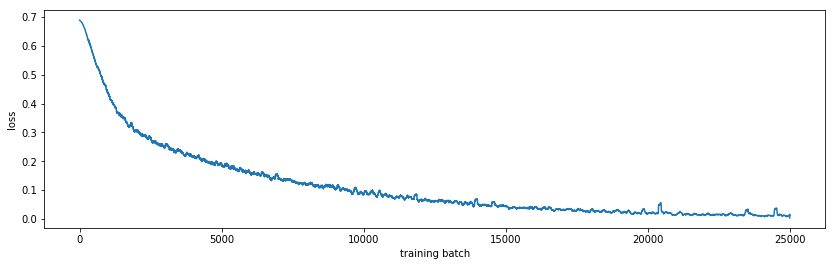

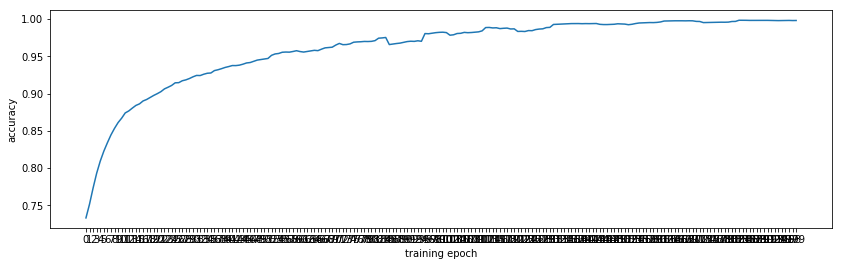

In [80]:
train_dataset, test_dataset = make_torch_train_test_datasets(ar_train, ar_test, en_train, en_test, encode_func=encode_word_onehot)
model = CNN()
losses, accuracies = train_model(model, train_dataset, num_epochs=200)
evaluate_model(model, losses, accuracies)